# Text Classification

In [1]:
# import dataset
import pandas as pd
df = pd.read_csv('imdb_indonesian_movies_2.csv')

# hapus judul film
df = df.drop(columns=['judul_film'])

# ubah genre jadi category
category = pd.get_dummies(df.genre)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='genre')
df_baru

# bagi data ke train dan test
sinopsis = df_baru['ringkasan_sinopsis'].values
label = df_baru[['Drama', 'Horor', 'Komedi', 'Laga', 'Romantis']].values
from sklearn.model_selection import train_test_split
sinopsis_latih, sinopsis_test, label_latih, label_test = train_test_split(sinopsis, label, test_size=0.2)

In [42]:
# melakukan tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sinopsis_latih) 
tokenizer.fit_on_texts(sinopsis_test)

sekuens_latih = tokenizer.texts_to_sequences(sinopsis_latih)
sekuens_test = tokenizer.texts_to_sequences(sinopsis_test)

padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

In [46]:
df

,ringkasan_sinopsis,genre
0,Raden Mas Said putra sulung Tumenggung Wilarik...,Drama
1,Soe Hok Gie adalah seorang aktivis yang hidup ...,Drama
2,Guru Bangsa Tjokroaminoto menceritakan tentang...,Drama
3,POL menceritakan kisah hidup yang luar biasa d...,Drama
4,Perjalanan pahlawan Indonesia KH Ahmad Dahlan ...,Drama
...,...,...
1000,Winter in Tokyo berpusat pada kehidupan Ishida...,Romantis
1001,Markonah melarikan diri ke Jakarta karena akan...,Romantis
1002,"Tempat aking lebih dari 36 jam, Last Night ada...",Romantis
1003,Proyek baru ini adalah tentang seorang lelaki ...,Romantis


In [3]:
# buat model arsitektur
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# compile model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [45]:
# fitting/latih model
num_epochs = 30
history = model.fit(padded_latih, label_latih, epochs=num_epochs, validation_data=(padded_test, label_test), verbose=2)

Train on 804 samples, validate on 201 samples
Epoch 1/30
804/804 - 3s - loss: 2.3247 - accuracy: 0.2251 - val_loss: 1.6076 - val_accuracy: 0.2189
Epoch 2/30
804/804 - 2s - loss: 1.5496 - accuracy: 0.3532 - val_loss: 1.6166 - val_accuracy: 0.2289
Epoch 3/30
804/804 - 2s - loss: 1.3737 - accuracy: 0.4577 - val_loss: 1.7166 - val_accuracy: 0.2537
Epoch 4/30
804/804 - 2s - loss: 1.0691 - accuracy: 0.5672 - val_loss: 1.9897 - val_accuracy: 0.2338
Epoch 5/30
804/804 - 2s - loss: 0.6982 - accuracy: 0.7637 - val_loss: 2.3526 - val_accuracy: 0.2488
Epoch 6/30
804/804 - 2s - loss: 0.3901 - accuracy: 0.8955 - val_loss: 2.9280 - val_accuracy: 0.2139
Epoch 7/30
804/804 - 2s - loss: 0.1768 - accuracy: 0.9552 - val_loss: 3.4178 - val_accuracy: 0.2637
Epoch 8/30
804/804 - 2s - loss: 0.0883 - accuracy: 0.9813 - val_loss: 3.6984 - val_accuracy: 0.2736
Epoch 9/30
804/804 - 2s - loss: 0.0435 - accuracy: 0.9913 - val_loss: 4.0584 - val_accuracy: 0.2338
Epoch 10/30
804/804 - 2s - loss: 0.0310 - accuracy: 0.

# Time Series

In [1]:
# import library
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# import dataset
data_train = pd.read_csv('DailyDelhiClimateTrain.csv')
data_train.tail()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
# mengecek data yang kosong/null
data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

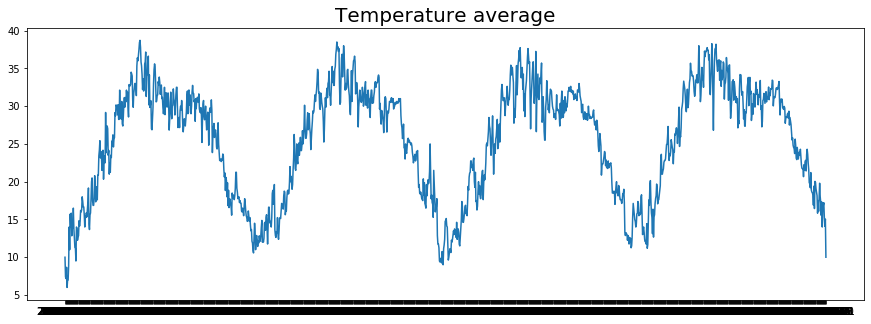

In [4]:
# menampilkan plot untuk menganalisis jenis data
dates = data_train['date'].values
temp  = data_train['meantemp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average', fontsize=20)

In [5]:
# mengubah data menjadi bentuk yang dapat dikenali oleh model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
# buat arsitektur model
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
])

In [7]:
# mengompile model
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# melakukan fitting pada model
history = model.fit(train_set,epochs=100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/100
15/15 [==============================] - 11s 753ms/step - loss: 25.4504 - mae: 25.6491
Epoch 2/100
15/15 [==============================] - 2s 103ms/step - loss: 25.0230 - mae: 25.5095
Epoch 3/100
15/15 [==============================] - 1s 83ms/step - loss: 24.8430 - mae: 25.3300
Epoch 4/100
15/15 [==============================] - 1s 98ms/step - loss: 24.6569 - mae: 25.1445
Epoch 5/100
15/15 [==============================] - 2s 106ms/step - loss: 24.4401 - mae: 24.9468
Epoch 6/100
15/15 [

# Binary classification

In [1]:
import pandas as pd
df = pd.read_csv('citrus.csv')
df.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
name        10000 non-null object
diameter    10000 non-null float64
weight      10000 non-null float64
red         10000 non-null int64
green       10000 non-null int64
blue        10000 non-null int64
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [3]:
df.describe()

,diameter,weight,red,green,blue
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.975685,175.050792,153.847800,76.010600,11.363200
std,1.947844,29.212119,10.432954,11.708433,9.061275
min,2.960000,86.760000,115.000000,31.000000,2.000000
25%,8.460000,152.220000,147.000000,68.000000,2.000000
50%,9.980000,174.985000,154.000000,76.000000,10.000000
75%,11.480000,197.722500,161.000000,84.000000,17.000000
max,16.450000,261.510000,192.000000,116.000000,56.000000


In [4]:
df.name[df.name == 'orange'] = 0
df.name[df.name == 'grapefruit'] = 1

In [5]:
dataset = df.values

In [6]:
# bilangan sebelum koma untuk memilih baris pada dataframe
# bilangan setelah koma untuk memilih kolom pada dataframe

# pilih 4 kolom terakhir sebagai atribut
X = dataset[:,1:6]

# pilih kolom pertama sebagai label
y = dataset[:,0]

In [7]:
# Normalization
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
X_scale

array([[0.        , 0.        , 0.74025974, 0.63529412, 0.        ],
       [0.07042254, 0.00738197, 0.66233766, 0.55294118, 0.01851852],
       [0.10822832, 0.04812589, 0.53246753, 0.58823529, 0.        ],
       ...,
       [0.93624907, 0.97133047, 0.68831169, 0.6       , 0.33333333],
       [0.96071164, 0.99216023, 0.35064935, 0.48235294, 0.16666667],
       [1.        , 1.        , 0.48051948, 0.50588235, 0.        ]])

In [8]:
# pisahkan data training dan testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, y, test_size=0.3)

In [9]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential([
    Dense(32, activation='relu', input_shape=(5,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),]
    )

Using TensorFlow backend.


In [10]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
7000/7000 [==============================] - 2s 249us/step - loss: 0.6586 - accuracy: 0.6967
Epoch 2/100
7000/7000 [==============================] - 1s 94us/step - loss: 0.5930 - accuracy: 0.9101
Epoch 3/100
7000/7000 [==============================] - 1s 105us/step - loss: 0.5146 - accuracy: 0.9203
Epoch 4/100
7000/7000 [==============================] - 1s 98us/step - loss: 0.4179 - accuracy: 0.9227
Epoch 5/100
7000/7000 [==============================] - 1s 117us/step - loss: 0.3325 - accuracy: 0.9237
Epoch 6/100
7000/7000 [==============================] - 1s 104us/step - loss: 0.2736 - accuracy: 0.9254
Epoch 7/100
7000/7000 [==============================] - 1s 111us/step - loss: 0.2384 - accuracy: 0.9253
Epoch 8/100
7000/7000 [==============================] - 1s 107us/step - loss: 0.2180 - accuracy: 0.9256
Epoch 9/100
7000/7000 [==============================] - 1s 98us/step - loss: 0.2053 - accuracy: 0.9266
Epoch 10/100
7000/7000 [==============================] - 

In [11]:
model.evaluate(X_test, Y_test)
# elemen pertama adalah loss dan elemen kedua adalah akurasi

3000/3000 [==============================] - 0s 89us/step


[0.17138496826092403, 0.9263333082199097]

# Multiclass Classification

In [12]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

In [13]:
df = pd.read_csv('Iris.csv')
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [14]:
df = df.drop(columns='Id')

In [15]:
category = pd.get_dummies(df.Species)
category

,Iris-setosa,Iris-versicolor,Iris-virginica
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
145,0,0,1
146,0,0,1
147,0,0,1
148,0,0,1


In [16]:
new_df = pd.concat([df, category], axis=1)
new_df = new_df.drop(columns='Species')
new_df

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Iris-setosa,Iris-versicolor,Iris-virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,0,0,1
146,6.3,2.5,5.0,1.9,0,0,1
147,6.5,3.0,5.2,2.0,0,0,1
148,6.2,3.4,5.4,2.3,0,0,1


In [17]:
dataset = new_df.values
dataset

array([[5.1, 3.5, 1.4, ..., 1. , 0. , 0. ],
       [4.9, 3. , 1.4, ..., 1. , 0. , 0. ],
       [4.7, 3.2, 1.3, ..., 1. , 0. , 0. ],
       ...,
       [6.5, 3. , 5.2, ..., 0. , 0. , 1. ],
       [6.2, 3.4, 5.4, ..., 0. , 0. , 1. ],
       [5.9, 3. , 5.1, ..., 0. , 0. , 1. ]])

In [18]:
# Pilih 4 kolom pertama untuk dijadikan sebagai atribut
X = dataset[:,0:4]
# Pilih 3 kolom terakhir sebagai label
y = dataset[:,4:7]

In [19]:
# Normalize
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
X_scale

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ],
       [0.30555556, 0.70833333, 0.08474576, 0.04166667],
       [0.13888889, 0.58333333, 0.10169492, 0.04166667],
       [0.13888889, 0.41666667, 0.06779661, 0.        ],
       [0.        , 0.41666667, 0.01694915, 0.        ],
       [0.41666667, 0.83333333, 0.03389831, 0.04166667],
       [0.38888889, 1.        , 0.08474576, 0.125     ],
       [0.30555556, 0.79166667, 0.05084746, 0.125     ],
       [0.22222222, 0.625     ,

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, y, test_size=0.3)

In [21]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax'),]
    )

In [22]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, Y_train, epochs=100)

Epoch 1/100
105/105 [==============================] - 0s 2ms/step - loss: 1.0732 - accuracy: 0.3714
Epoch 2/100
105/105 [==============================] - 0s 294us/step - loss: 1.0405 - accuracy: 0.4857
Epoch 3/100
105/105 [==============================] - 0s 266us/step - loss: 1.0106 - accuracy: 0.6476
Epoch 4/100
105/105 [==============================] - 0s 275us/step - loss: 0.9828 - accuracy: 0.7143
Epoch 5/100
105/105 [==============================] - 0s 256us/step - loss: 0.9541 - accuracy: 0.7714
Epoch 6/100
105/105 [==============================] - 0s 228us/step - loss: 0.9242 - accuracy: 0.7619
Epoch 7/100
105/105 [==============================] - 0s 237us/step - loss: 0.8939 - accuracy: 0.7143
Epoch 8/100
105/105 [==============================] - 0s 209us/step - loss: 0.8626 - accuracy: 0.6952
Epoch 9/100
105/105 [==============================] - 0s 199us/step - loss: 0.8300 - accuracy: 0.6952
Epoch 10/100
105/105 [==============================] - 0s 228us/step - los

In [23]:
model.evaluate(X_test, Y_test)

45/45 [==============================] - 0s 754us/step


[0.06160232557190789, 0.9777777791023254]

# Plot Loss and Accuracy

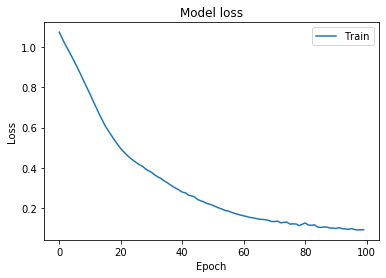

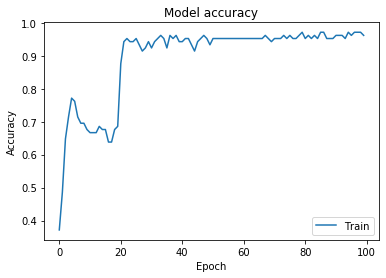

In [25]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

plt.plot(hist.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

# Callback

In [38]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.98):
            print("\nAkurasi telah mencapai >98%!")
            self.model.stop_training = True
callbacks = myCallback()

In [39]:
model.fit(X_train, Y_train, epochs=50, callbacks=[callbacks])

Epoch 1/50
105/105 [==============================] - 0s 199us/step - loss: 0.0558 - accuracy: 0.9714
Epoch 2/50
105/105 [==============================] - 0s 199us/step - loss: 0.0577 - accuracy: 0.9810

Akurasi telah mencapai >98%!


# Split Train Val With Imagedatagen

In [ ]:
directory = os.path.join('/tmp/Chessman-image-dataset/Chess')
datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode = 'nearest',
    validation_split=0.1) # set validation split

In [ ]:
train_generator = datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=8,
    class_mode='categorical',
    subset='training') # set as training data
validation_generator = datagen.flow_from_directory(
    directory, # same directory as training data
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    subset='validation')

# Transfer Learning

In [ ]:
!wget --no-check-certificate \
    https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pengembangan_academy/Chessman-image-dataset.zip \
    -O /tmp/Chessman-image-dataset.zip

In [ ]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
local_zip = '/tmp/Chessman-image-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
train_dir = os.path.join('/tmp/Chessman-image-dataset/Chess')
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode = 'nearest',
    validation_split=0.1) # set validation split

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=8,
    class_mode='categorical',
    subset='training') # set as training data
validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    subset='validation')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  
])
model.layers[0].trainable = False

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=1)

# TF-Agents and Deep Q-Network

In [ ]:
import tensorflow as tf
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
    
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(100,))
    
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=tf.Variable(0))
    
agent.initialize()

# more https://www.tensorflow.org/agents